Problem Set 3: Structured Perceptron
====================

In this problem set, you will implement a sequence labeling algorithm that is near state-of-the-art: structured perceptron. To do this, you will use several functions that you have written earlier, especially Viterbi and averaged perceptron.

The problem set is designed to highlight the connection between structured perceptron and classification-based tagging. You will first write most of the pieces that you need while working in the framework of classification-based tagging. Your implementation will take various tagging algorithms as arguments, including both one-word-at-a-time classification based tagging, and Viterbi sequence labeling.

One of the main reasons to prefer perceptron over hidden Markov models is the ability to use rich, overlapping features. You will design several feature functions throughout the assignment.

Because structure perceptron is slower to train than the hidden Markov model, we will use smaller datasets in this assignment, focusing on sentences that contain the most common POS tags in English and Japanese.

In [1]:
from gtnlplib import preproc, tagger_base, scorer 
from gtnlplib import features, viterbi, constants, structure_perceptron, kaggle

import os
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

/Users/sylviachan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## Demo
## NOTE! These datafiles are different than in pset2. Don't copy over constants.py from that pset.
all_tags = set()
for i,(words, tags) in enumerate(preproc.conll_seq_generator(constants.TRAIN_FILE,max_insts=100000)):
    for tag in tags:
        all_tags.add(tag)
print("English tags: {}".format(all_tags))

all_tags_ja = set()
for i,(words, tags) in enumerate(preproc.conll_seq_generator(constants.JA_TRAIN_FILE,max_insts=100000)):
    for tag in tags:
        all_tags_ja.add(tag)
print("Japanese tags: {}".format(all_tags_ja))

English tags: set([u'ADV', u'NOUN', u'ADP', u'PRON', u'PROPN', u'DET', u'PUNCT', u'VERB', u'AUX', u'ADJ'])
Japanese tags: set([u'ADV', u'NOUN', u'PRON', u'DET', u'PUNCT', u'VERB', u'NUM', u'ADJ'])


# 1. Tagging as discriminative classification

In pset 2, you performed part-of-speech tagging as generative classification, using Naive Bayes. Now you will perform discriminative classification, using average perceptron.

In this section, we are only doing classification-based tagging, but we will write the code in a way that generalizes to Viterbi-based structure prediction. This means that all features are of the form $f(\boldsymbol{w},y_m,y_{m-1},m)$.

**Deliverable 1.1** Implement `features.word_feats` to output features that are tuples `(y,constants.CURR_WORD_FEAT,w[m])` and `(y,constants.OFFSET)`.

(*0.7 points*)

In [3]:
reload(features);

In [4]:
print(features.word_feats(['The','old','man','the','boat'],'NOUN','ADJ',2))
print(features.word_feats(['The','old','man','the','boat'],'VERB','NOUN',3))
# note that we may need to handle m >= len(tokens)
print(features.word_feats(['The','old','man','the','boat'],'NOUN','ADJ',5))

{('NOUN', '**OFFSET**'): 1, ('NOUN', '--CURR-WORD--', 'man'): 1}
{('VERB', '--CURR-WORD--', 'the'): 1, ('VERB', '**OFFSET**'): 1}
{('NOUN', '**OFFSET**'): 1}


**Deliverable 1.2** Reimplement `tagger_base.classifier_tagger` as follows:

Inputs:

- List of tokens to tag
- Feature function, of the form $f(\boldsymbol{w},y_m,y_{m-1},m)$
- Defaultdict of weights
- List of all candidate tags

Outputs:

- List of predicted tags
- Score of predicted tag sequence $\theta \cdot f(\boldsymbol{w},\boldsymbol{y})$

(*0.7 points*)

In [5]:
theta_clf_hand = defaultdict(float,
                             {('NOUN',constants.OFFSET):0.1,
                              ('PRON',constants.CURR_WORD_FEAT,'They'):1,
                              ('PRON',constants.CURR_WORD_FEAT,'can'):-1,
                              ('NOUN',constants.CURR_WORD_FEAT,'fish'):1,
                              ('VERB',constants.CURR_WORD_FEAT,'fish'):0.5})

In [6]:
w = 'They can fish'.split()
print(w)

['They', 'can', 'fish']


In [7]:
reload(tagger_base);

In [8]:
tagger_base.classifier_tagger(w,features.word_feats,theta_clf_hand,all_tags)

([u'PRON', u'NOUN', u'NOUN'], 2.2)

**Deliverable 1.3** The perceptron update requires computing the difference

\begin{align}
& f(\boldsymbol{w},\boldsymbol{y}) - f(\boldsymbol{w},\hat{\boldsymbol{y}})\\
= & \sum_{m=1}^M f(\boldsymbol{w},y_m,y_{m-1},m) - f(\boldsymbol{w},\hat{y}_m,\hat{y}_{m-1},m)
\end{align}

Implement `tagger_base.compute_features` to compute $f(\boldsymbol{w},\boldsymbol{y})$, with the following arguments:

- A list of words
- A list of tags
- A feature function, of the form $f(\boldsymbol{w},y_m,y_{m-1},m)$.

The output should be a dict of features and counts.

*Boundary cases*: 

- When $m=0$, use the special case $y_{-1} = \text{START}$, using `constants.START_TAG`. *Your current feature function will not test this, because it ignores $y_{m-1}$, but we will test it later*.
- When $m=M$, use the special case $y_M = \text{STOP}$, using `constants.END_TAG`. 

These boundary cases will be important when you incorporate Viterbi tagging.

(*0.7 points*)

In [9]:
reload(tagger_base);

In [10]:
tagger_base.compute_features('the old man the boat'.split(),
                            ['DET','NOUN','VERB','DET','NOUN'],
                            features.word_feats)

defaultdict(float,
            {('--END--', '**OFFSET**'): 1.0,
             ('DET', '**OFFSET**'): 2.0,
             ('DET', '--CURR-WORD--', 'the'): 2.0,
             ('NOUN', '**OFFSET**'): 2.0,
             ('NOUN', '--CURR-WORD--', 'boat'): 1.0,
             ('NOUN', '--CURR-WORD--', 'old'): 1.0,
             ('VERB', '**OFFSET**'): 1.0,
             ('VERB', '--CURR-WORD--', 'man'): 1.0})

**Deliverable 1.4**

Now you can implement the function `structure_perceptron.sp_update`. 

This will be very similar to your implementation of `perceptron.perceptron_update` in pset 1, but instead of calling `clf_base.predict`, you should call a function `tagger` which is passed in as an argument.

(*0.7 points*)

In [11]:
reload(structure_perceptron);

In [12]:
tagger_base.classifier_tagger('They can fish'.split(),
                             features.word_feats,
                             theta_clf_hand,
                             all_tags)

([u'PRON', u'NOUN', u'NOUN'], 2.2)

In [13]:
update = structure_perceptron.sp_update('They can fish'.split(),
                               ['PRON','AUX','VERB'],
                               theta_clf_hand,
                               features.word_feats,
                               tagger_base.classifier_tagger,
                               all_tags)

In [14]:
for key,val in update.iteritems():
    if val != 0:
        print(key,val)

((u'NOUN', '--CURR-WORD--', 'fish'), -1.0)
((u'NOUN', '**OFFSET**'), -2.0)
(('AUX', '--CURR-WORD--', 'can'), 1.0)
(('VERB', '--CURR-WORD--', 'fish'), 1.0)
(('VERB', '**OFFSET**'), 1.0)
((u'NOUN', '--CURR-WORD--', 'can'), -1.0)
(('AUX', '**OFFSET**'), 1.0)


**Deliverable 1.5**

You are now ready to implement `structure_perceptron.estimate_perceptron`.

Your implementation will be nearly identical to `perceptron.estimate_perceptron`, except for two things:

- The input is now a list of (token-list, tag-list) tuples
- Instead of calling `perceptron.perceptron_update`, you will call `structure_perceptron.sp_update`.

Other aspects of the implementation, such as weight averaging, should be identical.

(*0.7 points*)

In [15]:
reload(features)
reload(tagger_base)
reload(structure_perceptron);

In [16]:
toy_data = [('They can fish'.split(),['PRON','AUX','VERB']),
            ('the old man the boat'.split(),['DET','NOUN','VERB','DET','NOUN'])]

In [17]:
theta_toy_one_inst,_ = structure_perceptron.estimate_perceptron(toy_data[:1],
                                                                features.word_feats,
                                                                tagger_base.classifier_tagger,
                                                                1,
                                                                all_tags)

In [18]:
features.word_feats(toy_data[0][0],'NOUN','IGNORE',0)

{('NOUN', '**OFFSET**'): 1, ('NOUN', '--CURR-WORD--', 'They'): 1}

In [19]:
for feat,weight in theta_toy_one_inst.iteritems():
    if weight != 0:
        print(feat,weight)

((u'PRON', '**OFFSET**'), 1.0)
((u'NOUN', '--CURR-WORD--', 'can'), -1.0)
((u'AUX', '--CURR-WORD--', 'can'), 1.0)
((u'VERB', '--CURR-WORD--', 'fish'), 1.0)
((u'VERB', '**OFFSET**'), 1.0)
(('NOUN', '**OFFSET**'), -2.999)
((u'NOUN', '--CURR-WORD--', 'They'), -1.0)
((u'AUX', '**OFFSET**'), 1.0)
((u'NOUN', '--CURR-WORD--', 'fish'), -1.0)
((u'PRON', '--CURR-WORD--', 'They'), 1.0)


In [20]:
theta_toy_one_inst,_ = structure_perceptron.estimate_perceptron(toy_data[:1],
                                                                features.word_feats,
                                                                tagger_base.classifier_tagger,
                                                                10,
                                                                all_tags)

In [21]:
for feat,weight in theta_toy_one_inst.iteritems():
    if weight != 0:
        print(feat,weight)

((u'PRON', '**OFFSET**'), 1.0)
((u'NOUN', '--CURR-WORD--', 'can'), -1.0)
((u'AUX', '--CURR-WORD--', 'can'), 1.0)
((u'VERB', '--CURR-WORD--', 'fish'), 1.0)
((u'VERB', '**OFFSET**'), 1.0)
(('NOUN', '**OFFSET**'), -2.999)
((u'NOUN', '--CURR-WORD--', 'They'), -1.0)
((u'AUX', '**OFFSET**'), 1.0)
((u'NOUN', '--CURR-WORD--', 'fish'), -1.0)
((u'PRON', '--CURR-WORD--', 'They'), 1.0)


In [22]:
theta_toy,_ = structure_perceptron.estimate_perceptron(toy_data,
                                                     features.word_feats,
                                                     tagger_base.classifier_tagger,
                                                     1, all_tags)

In [23]:
for feat,weight in theta_toy.iteritems():
    if weight != 0:
        print(feat,weight)

((u'PRON', '--CURR-WORD--', 'man'), -0.5)
((u'PRON', '**OFFSET**'), -1.5)
((u'NOUN', '--CURR-WORD--', 'can'), -1.0)
((u'PRON', '--CURR-WORD--', 'old'), -0.5)
((u'PRON', '--CURR-WORD--', 'the'), -1.0)
((u'VERB', '--CURR-WORD--', 'man'), 0.5)
((u'AUX', '--CURR-WORD--', 'can'), 1.0)
((u'VERB', '--CURR-WORD--', 'fish'), 1.0)
((u'VERB', '**OFFSET**'), 1.5)
((u'PRON', '--CURR-WORD--', 'boat'), -0.5)
((u'PRON', '--CURR-WORD--', 'They'), 1.0)
(('NOUN', '**OFFSET**'), -1.999)
((u'NOUN', '--CURR-WORD--', 'old'), 0.5)
((u'NOUN', '--CURR-WORD--', 'They'), -1.0)
((u'AUX', '**OFFSET**'), 1.0)
((u'NOUN', '--CURR-WORD--', 'fish'), -1.0)
((u'NOUN', '--CURR-WORD--', 'boat'), 0.5)
((u'DET', '**OFFSET**'), 1.0)
((u'DET', '--CURR-WORD--', 'the'), 1.0)


** Deliverable 1.6 ** Let's train this tagger and evaluate it.

(*0.5 points*)

In [24]:
training_set = [inst for inst in preproc.conll_seq_generator(constants.TRAIN_FILE)]

In [25]:
len(training_set)

3531

The cell below takes 30 seconds to run on my laptop.

In [26]:
theta_avp,theta_hist = structure_perceptron.estimate_perceptron(training_set,
                                                       features.word_feats,
                                                       tagger_base.classifier_tagger,
                                                       20,
                                                       all_tags)

In [27]:
tagger_base.eval_tagging_model(constants.DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_feats,
                               theta_avp,
                               all_tags,
                               'avp-words.preds')

0.8129496402877698

In [28]:
tagger_base.apply_tagging_model(constants.TEST_FILE_HIDDEN,
                               tagger_base.classifier_tagger,
                               features.word_feats,
                               theta_avp,
                               all_tags,
                               'avp-words-te.preds')

In [29]:
# you can't run this line
scorer.accuracy(scorer.get_confusion(constants.TEST_FILE,'avp-words-te.preds'))

IOError: [Errno 2] No such file or directory: 'data/en-ud-simpler-test.conllu'

Now let's see how accuracy improved over training. 
You can use this function elsewhere in the notebook if you'd like to see the progress of your classifier.

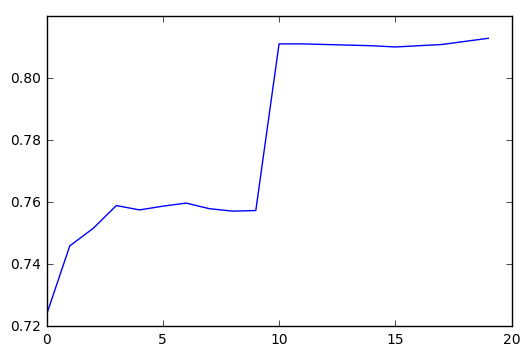

In [30]:
tagger_base.plot_learning_curve(constants.DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_feats,
                               theta_hist,
                               all_tags);

These accuracies are not directly comparable with your HMM accuracies from pset2, since we are using a different dataset.

Let's see how many features are active.

In [31]:
print("Number of active features: %d"%len([val for val in theta_avp.values() if val != 0]))

Number of active features: 19265


**Deliverable 1.7** Now try it on Japanese. 

(*0.5 points for 4650 / 0.25 points for 7650*)

As before, 4650 students can opt in to 7650 grading by doing the 7650 problems.

Please set the `GRADING` variable in `constants.py` to the appropriate grading scheme. Note that CS7650 students must be graded by the CS7650 rubric.

In [32]:
training_set_ja = [inst for inst in preproc.conll_seq_generator(constants.JA_TRAIN_FILE)]

The cell below takes approximately 40 seconds to run on my laptop.

In [33]:
theta_avp_ja,theta_hist_ja =\
structure_perceptron.estimate_perceptron(training_set_ja,
                                         features.word_feats,
                                         tagger_base.classifier_tagger,
                                         20,
                                         all_tags_ja)

In [34]:
tagger_base.eval_tagging_model(constants.JA_DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_feats,
                               theta_avp_ja,
                               all_tags_ja,
                               'avp-words.ja.preds')

0.790288213524728

In [35]:
tagger_base.apply_tagging_model(constants.JA_TEST_FILE_HIDDEN,
                               tagger_base.classifier_tagger,
                               features.word_feats,
                               theta_avp_ja,
                               all_tags_ja,
                               'avp-words-te.ja.preds')

In [39]:
# you can't run this
scorer.accuracy(scorer.get_confusion(constants.JA_TEST_FILE,'avp-words-te.ja.preds'))

0.7513812154696132

**Deliverable 1.8 (for 7650)** As you can see from the cells here, this tagging model is less accurate for Japanese than it is for English. Why might that be? (I'm looking for an explanation that is based on quantitative facts about the datasets.) Put your answer in `text-answers.md`.

(*0.5 points for 7650, optional for 4650*)

# Part 2. Better features

One simple way to improve tagging is to add better features to the classification-based tagger. 

**Deliverable 2.1** Let's start by adding features that include the final two characters of each word as an additional, suffix feature. Do this by implementing `word_suff_features` in `features.py`.

(*0.5 points*)

In [36]:
reload(constants)
reload(features);

In [37]:
print(features.word_suff_feats(['The','old','man','a','boat'],'DET','ADJ',0))
print(features.word_suff_feats(['The','old','man','a','boat'],'NOUN','DET',1))
print(features.word_suff_feats(['The','old','man','a','boat'],'NOUN','ADJ',3))

{('DET', '--CURR-WORD--', 'The'): 1, ('DET', '**OFFSET**'): 1, ('DET', '--SUFFIX--', 'he'): 1}
{('NOUN', '--SUFFIX--', 'ld'): 1, ('NOUN', '**OFFSET**'): 1, ('NOUN', '--CURR-WORD--', 'old'): 1}
{('NOUN', '**OFFSET**'): 1, ('NOUN', '--SUFFIX--', 'a'): 1, ('NOUN', '--CURR-WORD--', 'a'): 1}


**Deliverable 2.2** Let's see whether this improves accuracy.

(*0.5 points for 4650, 0.25 points for 7650. Includes both English and Japanese evaluations.*)

In [38]:
reload(features);

The cell below takes 50 seconds to run on my laptop.

In [39]:
theta_suff_avp,_ =\
structure_perceptron.estimate_perceptron(training_set,
                                         features.word_suff_feats,
                                         tagger_base.classifier_tagger,
                                         20,
                                         all_tags)

In [40]:
print('EN dev set')
tagger_base.eval_tagging_model(constants.DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_suff_feats,
                               theta_suff_avp,
                               all_tags,
                               'avp-words-suff.preds')

EN dev set


0.8439248601119105

In [41]:
tagger_base.apply_tagging_model(constants.TEST_FILE_HIDDEN,
                               tagger_base.classifier_tagger,
                               features.word_suff_feats,
                               theta_suff_avp,
                               all_tags,
                               'avp-words-suff-te.preds')

In [42]:
# you cannot run this
scorer.accuracy(scorer.get_confusion(constants.TEST_FILE,'avp-words-suff-te.preds'))

IOError: [Errno 2] No such file or directory: 'data/en-ud-simpler-test.conllu'

This is 3% better than the word-only feature set! That's pretty good for adding a single feature template. Now let's try Japanese. 

The cell below takes 45 seconds to execute on my laptop.

In [43]:
theta_suff_avp_ja,_ =\
structure_perceptron.estimate_perceptron(training_set_ja,
                                         features.word_suff_feats,
                                         tagger_base.classifier_tagger,
                                         20,
                                         all_tags_ja)

In [44]:
print('JA dev set')
tagger_base.eval_tagging_model(constants.JA_DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_suff_feats,
                               theta_suff_avp_ja,
                               all_tags_ja,
                               'avp-words-suff.ja.preds')

JA dev set


0.8816866659190311

10% better on Japanese! Why might that be?

In [45]:
tagger_base.apply_tagging_model(constants.JA_TEST_FILE_HIDDEN,
                               tagger_base.classifier_tagger,
                               features.word_suff_feats,
                               theta_suff_avp_ja,
                               all_tags,
                               'avp-words-suff-te.ja.preds')

In [54]:
# you can't run this
scorer.accuracy(scorer.get_confusion(constants.JA_TEST_FILE,'avp-words-suff-te.ja.preds'))

0.8445672191528545

**Deliverable 2.3 (7650)** Briefly explain why you think suffix features are so helpful in Japanese. No prior Japanese knowledge is assumed! You may want to look at the raw data, and consult some resources about Japanese that you can find from a quick Google search. Put your answer in `text-answers.md`.

(*0.5 points for 7650, optional for 4650*)

**Deliverable 2.4** Now implement word neighbor features. These are features that should link a given tag to the words than come before and after it. Implement this function in `features.word_neighbor_feats`, and make sure it gives the same results as in the example cell below. Pay attention to the boundary case at the end. See `constants.PRE_START_TOKEN` and `constants.POST_END_TOKEN`.

(*0.5 points*)

In [46]:
reload(constants)
reload(features);

In [47]:
for m in xrange(6):
    feats = features.word_neighbor_feats(['The','old','man','a','boat'],'TAG','IGNORE',m)
    for feat,count in feats.iteritems():
        print('{}: {}'.format(feat,count))
    print 

('TAG', '--CURR-WORD--', 'The'): 1
('TAG', '**OFFSET**'): 1
('TAG', '--PREV-WORD--', '[[START]]'): 1
('TAG', '--NEXT-WORD--', 'old'): 1

('TAG', '**OFFSET**'): 1
('TAG', '--NEXT-WORD--', 'man'): 1
('TAG', '--PREV-WORD--', 'The'): 1
('TAG', '--CURR-WORD--', 'old'): 1

('TAG', '**OFFSET**'): 1
('TAG', '--NEXT-WORD--', 'a'): 1
('TAG', '--CURR-WORD--', 'man'): 1
('TAG', '--PREV-WORD--', 'old'): 1

('TAG', '**OFFSET**'): 1
('TAG', '--CURR-WORD--', 'a'): 1
('TAG', '--PREV-WORD--', 'man'): 1
('TAG', '--NEXT-WORD--', 'boat'): 1

('TAG', '**OFFSET**'): 1
('TAG', '--NEXT-WORD--', '[[END]]'): 1
('TAG', '--PREV-WORD--', 'a'): 1
('TAG', '--CURR-WORD--', 'boat'): 1

('TAG', '**OFFSET**'): 1
('TAG', '--PREV-WORD--', 'boat'): 1



**Deliverable 2.5** Let's try it, in both English and Japanese.

(*0.5 points for 4650, 0.25 points for 7650*)

The code below takes 60 seconds to run on my laptop.

In [48]:
theta_neighbor_avp,_ =\
structure_perceptron.estimate_perceptron(training_set,
                                         features.word_neighbor_feats,
                                         tagger_base.classifier_tagger,
                                         20,
                                         all_tags)

In [49]:
print('EN dev set')
tagger_base.eval_tagging_model(constants.DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_neighbor_feats,
                               theta_neighbor_avp,
                               all_tags,
                               'avp-words-neighbor.preds')

EN dev set


0.8577138289368506

Even better for English than the suffix features! Let's try Japanese.

The code below takes 60 seconds to run on my laptop.

In [50]:
theta_neighbor_avp_ja,_ =\
structure_perceptron.estimate_perceptron(training_set_ja,
                                         features.word_neighbor_feats,
                                         tagger_base.classifier_tagger,
                                         20,
                                         all_tags_ja)

In [51]:
print('JA dev set')
tagger_base.eval_tagging_model(constants.JA_DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_neighbor_feats,
                               theta_neighbor_avp_ja,
                               all_tags_ja,
                               'avp-words-neighbor.ja.preds')

JA dev set


0.8020634742626443

The neighbor features don't help nearly as much in Japanese, compared to the impact they make in English.

## BAKEOFF #1

**Deliverable 2.6** Implement the best features that you can for English and Japanese.
You can use the same features for each, or you can use different features.
You can also train the model longer, if you think that will help.

Make sure to save the output in the following files:

- **English dev**: `avp-best.preds`
- **English test**: `avp-best-te.preds`
- **Japanese dev**: `avp-best.ja.preds`
- **Japanese test**: `avp-best-te.ja.preds`

Grading:
- Full credit (0.5 pts) for **88%** accuracy on English dev set, half credit (0.25 pts) for **87%** dev set accuracy.
- Full credit (0.5 pts) for **90%** accuracy on Japanese dev set, half credit (0.25 pts) for **89%** dev set accuracy.
- +0.1 for beating my test set score on English
- +0.1 for beating my test set score on Japanese
- +0.2 for top English score in 4650
- +0.2 for top English score in 7650
- +0.2 for top Japanese score in 4650
- +0.2 for top Japanese score in 7650

If you want to use an external library that is not standard with Python, please ask. For this part of the assignment, we will be more open to the use of 3rd party code, as long as it can be incorporated into your feature function. Libraries that include models that were trained on POS-labeled data will not be allowed. **We must be able to run your code to regenerate your outputs.**

### Getting Started With Kaggle
In this bakeoff and the one at the end of this problem set, you will submit your results on the test data to Kaggle, which will keep an updated leaderboard of the best taggers in the class.

Above each code snippet that outputs a file that you need to submit to Kaggle will be a link inviting you to the competition.  *NOTE THERE ARE 4 SEPARATE COMPETITIONS*, one for each combo of English and Japanese with AVP and Structure Prediction.  Make sure to submit the correct file to the correct competition.

Your Kaggle account needs to be registered with an @gatech.edu email to join.  Also, please make your display name your real name.

The public leaderboard shows how your taggers compare to your classmates on 50% of the test data.  The final standings on 100% of the test data will be released after the competition is over.

### English

In [52]:
reload(features);

In [53]:
# for my best classification-based tagger, I trained the model for 30 iterations
# this took a few minutes
theta_best_avp,theta_best_avp_hist =\
structure_perceptron.estimate_perceptron(training_set,
                                         features.word_feats_competitive_en,
                                         tagger_base.classifier_tagger,
                                         30,
                                         all_tags)

In [54]:
print('EN dev set')
dev_results = tagger_base.eval_tagging_model(constants.DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_feats_competitive_en,
                               theta_best_avp,
                               all_tags,
                               'avp-words-best.preds')
print(dev_results)
tagger_base.apply_tagging_model(constants.TEST_FILE_HIDDEN,
                               tagger_base.classifier_tagger,
                               features.word_feats_competitive_en,
                               theta_best_avp,
                               all_tags,
                               'avp-words-best-te.preds')

# SUBMIT KAGGLE-avp-bakeoff1-en-test.csv TO https://kaggle.com/join/gtclassificationtaggingen
kaggle.kaggle_output(constants.TEST_FILE_HIDDEN,
                                tagger_base.classifier_tagger,
                                features.word_feats_competitive_en,
                                theta_best_avp,
                                all_tags,
                                'KAGGLE-avp-bakeoff1-en-test.csv')

EN dev set
0.893685051958


In [53]:
# you can't run this
scorer.accuracy(scorer.get_confusion(constants.TEST_FILE,'avp-words-best-te.preds'))

0.8873505349276274

### Japanese

In [55]:
reload(features);

In [56]:
theta_best_avp_ja,theta_best_avp_hist_ja =\
structure_perceptron.estimate_perceptron(training_set_ja,
                                         features.word_feats_competitive_ja,
                                         tagger_base.classifier_tagger,
                                         30,
                                         all_tags_ja)

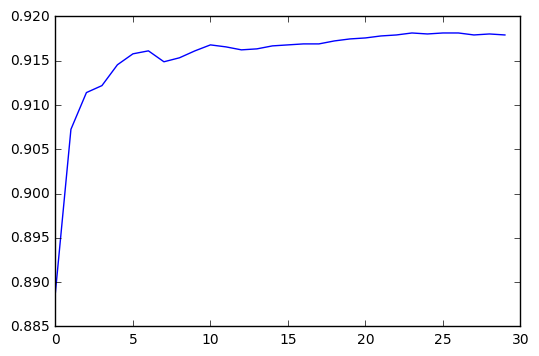

In [57]:
# as you can see, in this case there was little advantage to training past ten iterations
tagger_base.plot_learning_curve(constants.JA_DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_feats_competitive_ja,
                               theta_best_avp_hist_ja,
                               all_tags_ja);

In [58]:
print('JA dev set')
dev_results = tagger_base.eval_tagging_model(constants.JA_DEV_FILE,
                               tagger_base.classifier_tagger,
                               features.word_feats_competitive_ja,
                               theta_best_avp_ja,
                               all_tags_ja,
                               'avp-words-best.ja.preds')
print(dev_results)
tagger_base.apply_tagging_model(constants.JA_TEST_FILE_HIDDEN,
                               tagger_base.classifier_tagger,
                               features.word_feats_competitive_ja,
                               theta_best_avp_ja,
                               all_tags_ja,
                               'avp-words-best-te.ja.preds')

# SUBMIT KAGGLE-avp-bakeoff1-ja-test.csv TO: https://kaggle.com/join/gtclassificationtaggingja
kaggle.kaggle_output(constants.JA_TEST_FILE_HIDDEN,
                                tagger_base.classifier_tagger,
                                features.word_feats_competitive_ja,
                                theta_best_avp_ja,
                                all_tags_ja,
                                'KAGGLE-avp-bakeoff1-ja-test.csv')

JA dev set
0.917909610856


In [58]:
# you can't run this
scorer.accuracy(scorer.get_confusion(constants.JA_TEST_FILE,'avp-words-best-te.ja.preds'))

0.8788213627992634

# 3. Structure prediction

We now want to incorporate the Viterbi algorithm into the part of speech tagger.

If you completed problem set 2, you can do this directly: just replace `tagger_base.classifier_tagger` with `viterbi.viterbi_tagger`. If the feature sets don't use any tag-transition features, then the outputs should be exactly the same.

**Deliverable 3.1** Verify that this works, using `features.word_feats`. If your code from pset2 was written correctly, you don't actually have to do anything here. The test `test_viterbi_is_same_d3_1` will test this.

(*0.5 points*)

In [255]:
reload(viterbi); # just in case you need to modify it
reload(structure_perceptron);

In [256]:
theta_toy_one_inst_classifier,_ = structure_perceptron.estimate_perceptron(toy_data,
                                                                features.word_feats,
                                                                tagger_base.classifier_tagger,
                                                                3,
                                                                all_tags)

In [257]:
theta_toy_one_inst_viterbi,_ = structure_perceptron.estimate_perceptron(toy_data,
                                                                features.word_feats,
                                                                viterbi.viterbi_tagger,
                                                                3,
                                                                all_tags)

In [258]:
theta_toy_one_inst_classifier == theta_toy_one_inst_viterbi

True

The main advantage of using the Viterbi algorithm for structure prediction is that you can use features that look at more than one tag at a time. 

**Deliverable 3.2** Implement `features.hmm_feats`. This will be very similar to `hmm.hmm_features` from problem set 2, we've only changed some of the constants.
(*0.5 points*)

In [248]:
reload(features);

In [249]:
toy_data

[(['They', 'can', 'fish'], ['PRON', 'AUX', 'VERB']),
 (['the', 'old', 'man', 'the', 'boat'],
  ['DET', 'NOUN', 'VERB', 'DET', 'NOUN'])]

In [250]:
print(features.hmm_feats(toy_data[0][0],'PRON',constants.START_TAG,0))
print(features.hmm_feats(toy_data[0][0],'AUX','PRON',1))
print(features.hmm_feats(toy_data[0][0],'VERB','AUX',2))
print(features.hmm_feats(toy_data[0][0],constants.END_TAG,'VERB',3))

{('PRON', '--CURR-WORD--', 'They'): 1, ('PRON', '--PREV-TAG--', '--START--'): 1}
{('AUX', '--CURR-WORD--', 'can'): 1, ('AUX', '--PREV-TAG--', 'PRON'): 1}
{('VERB', '--CURR-WORD--', 'fish'): 1, ('VERB', '--PREV-TAG--', 'AUX'): 1}
{('--END--', '--PREV-TAG--', 'VERB'): 1}


**Deliverable 3.3** Evaluate the performance of this structured perceptron on the dev data.

This will be slower than the perceptrons that you have trained in the earlier parts of this assignment.

(*0.5 points for 4650, 0.25 points for 7650*)

This cell takes three minutes to execute on my laptop.

In [251]:
#English
theta_hmm_sp,_ =\
structure_perceptron.estimate_perceptron(training_set,
                                         features.hmm_feats,
                                         viterbi.viterbi_tagger,
                                         15,
                                         all_tags)


In [252]:
print('EN dev set')
dev_results = tagger_base.eval_tagging_model(constants.DEV_FILE,
                               viterbi.viterbi_tagger,
                               features.hmm_feats,
                               theta_hmm_sp,
                               all_tags,
                               'sp-hmm.preds')
print(dev_results)

EN dev set
0.870303756994


This is better than many of the fancier feature sets that we tried using the classification-based tagger. 

That's the power of structured prediction!

Now let's try Japanese. This cell takes a little more than two minutes to run on my laptop.

In [253]:
#Japanese
theta_hmm_sp_ja,_ =\
structure_perceptron.estimate_perceptron(training_set_ja,
                                         features.hmm_feats,
                                         viterbi.viterbi_tagger,
                                         15,
                                         all_tags_ja)

In [254]:
print('JA dev set')
dev_results = tagger_base.eval_tagging_model(constants.JA_DEV_FILE,
                               viterbi.viterbi_tagger,
                               features.hmm_feats,
                               theta_hmm_sp_ja,
                               all_tags_ja,
                               'sp-hmm.ja.preds')
print(dev_results)

JA dev set
0.803745654368


The improvement for Japanese is much more limited.

# Bakeoff #2

**Deliverable 3.4** Implement the best features that you can for English and Japanese, this time using structured prediction with viterbi tagging.

Make sure to save the output in the following files:

- **English dev**: `sp-best.preds`
- **English test**: `sp-best-te.preds`
- **Japanese dev**: `sp-best.ja.preds`
- **Japanese test**: `sp-best-te.ja.preds`

Grading:
- Full credit (0.5 points) for **89.5%** accuracy on English dev set, half credit (0.25 points) for **88.5%** accuracy.
- Full credit (0.5 points) for **91%** accuracy on Japanese dev set, half credit (0.25 points) for **90%** accuracy.
- +0.1 for beating my test set score on English
- +0.1 for beating my test set score on Japanese
- +0.2 for top English test set score in 4650
- +0.2 for top English test set score in 7650
- +0.2 for top Japanese test set score in 4650
- +0.2 for top Japanese test set score in 7650


### Kaggle Notes
Refer back to the Kaggle note under Bakeoff #1 if you need a reminder what to do.
If you would like to implement a better tagger such as Conditional Random Fields in order to compete in the competition, you may do that.  If you just want to feature engineer structured perceptron, that is fine.
You may *NOT* use outside libraries like Scikit-Learn or TensorFlow if you decide to create an alternate tagger

In [263]:
reload(features);

In [ ]:
theta_best_sp,theta_best_sp_hist =\
structure_perceptron.estimate_perceptron(training_set,
                                         features.hmm_feats_competitive_en,
                                         viterbi.viterbi_tagger,
                                         30,
                                         all_tags)

In [261]:
len([val for val in theta_best_sp.values() if val != 0])

37163

In [262]:
print('EN dev set')
dev_results = tagger_base.eval_tagging_model(constants.DEV_FILE,
                               viterbi.viterbi_tagger,
                               features.hmm_feats_competitive_en,
                               theta_best_sp,
                               all_tags,
                               'sp-best.preds')
print(dev_results)

EN dev set
0.872901678657


In [64]:
tagger_base.apply_tagging_model(constants.TEST_FILE_HIDDEN,
                                viterbi.viterbi_tagger,
                                features.hmm_feats_competitive_en,
                                theta_best_sp,
                                all_tags,
                                'sp-best-te.preds')

# SUBMIT KAGGLE-sp-bakeoff2-en-test.csv to https://kaggle.com/join/gt46507650spenpset3
kaggle.kaggle_output(constants.TEST_FILE_HIDDEN,
                                viterbi.viterbi_tagger,
                                features.hmm_feats_competitive_en,
                                theta_best_sp,
                                all_tags,
                                'KAGGLE-sp-bakeoff2-en-test.csv')

In [65]:
# you can't run this
scorer.accuracy(scorer.get_confusion(constants.TEST_FILE,'sp-best-te.preds'))

0.8873505349276274

In [70]:
len([val for val in theta_best_sp.values() if val != 0])

43028

## Japanese

In [71]:
theta_best_sp_ja,_ =\
structure_perceptron.estimate_perceptron(training_set_ja,
                                         features.hmm_feats_competitive_ja,
                                         viterbi.viterbi_tagger,
                                         30,
                                         all_tags_ja)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29


In [72]:
# number of features
len([val for val in theta_best_sp_ja.values() if val != 0])

67002

In [75]:
print('JA dev set')
dev_results = tagger_base.eval_tagging_model(constants.JA_DEV_FILE,
                               viterbi.viterbi_tagger,
                               features.hmm_feats_competitive_ja,
                               theta_best_sp_ja,
                               all_tags_ja,
                               'sp-best.ja.preds')
print(dev_results)
tagger_base.apply_tagging_model(constants.JA_TEST_FILE_HIDDEN,
                                viterbi.viterbi_tagger,
                                features.hmm_feats_competitive_ja,
                                theta_best_sp_ja,
                                all_tags_ja,
                                'sp-best-te.ja.preds')

# SUBMIT KAGGLE-sp-bakeoff2-ja-test.csv to https://kaggle.com/join/gtcs46507650pset3ja
kaggle.kaggle_output(constants.JA_TEST_FILE_HIDDEN,
                                viterbi.viterbi_tagger,
                                features.hmm_feats_competitive_ja,
                                theta_best_sp_ja,
                                all_tags_ja,
                                'KAGGLE-sp-bakeoff2-ja-test.csv')

JA dev set
0.921273971067


In [76]:
# you can't run this
scorer.accuracy(scorer.get_confusion(constants.JA_TEST_FILE,'sp-best-te.ja.preds'))

0.879926335174954